In [62]:
import pandas as pd
import math as math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

#import warnings
#warnings.filterwarnings("ignore")

### Data preparation 1 - no scaling

In [2]:
# Read data
data_pathname = '/Users/danielbrand/Documents/Uni/Master/2. Semester/Artificial Intelligence & Robotics/Final Project/telco_final.csv'
data = pd.read_csv(data_pathname)
# Assign X and y
X = data.loc[:, data.columns != 'churn']
y = data.churn
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 1)

### Data preparation 2 - scaling

In [3]:
sc = StandardScaler()
# transforming the data using StandardScaler
X_train_scaled_data = sc.fit_transform(X_train.values)
X_test_scaled_data = sc.transform(X_test.values)
# converting transformed data back into data frame with original column names
X_train_scaled = pd.DataFrame(X_train_scaled_data, columns = data.loc[:, data.columns != 'churn'].columns)
X_test_scaled = pd.DataFrame(X_test_scaled_data, columns = data.loc[:, data.columns != 'churn'].columns)

### Model evaluation 1 - Scaled vs. unscaled data

In [37]:
# settings
cv_setting = 5
rs = 1

# max_iter = 50 because of performance reasons
mlp_unscaled = MLPClassifier(random_state = rs, max_iter = 50).fit(X_train, y_train)
val_scores_unscaled = cross_val_score(mlp_unscaled, X_test, y_test, cv = cv_setting)
print("Accuracy unscaled: %0.2f (+/- %0.2f)" % (val_scores_unscaled.mean(), val_scores_unscaled.std() * 2 ))
                             
mlp_scaled = MLPClassifier(random_state = rs, max_iter = 50).fit(X_train_scaled_data, y_train)
val_scores_scaled = cross_val_score(mlp_scaled, X_test_scaled, y_test, cv = cv_setting)
print("Accuracy scaled: %0.2f (+/- %0.2f)" % (val_scores_scaled.mean(), val_scores_scaled.std() * 2 ))

Accuracy unscaled: 0.75 (+/- 0.11)
Accuracy scaled: 0.79 (+/- 0.05)


### Model evaluation 2 - Nodes in hidden layer

Max test accuracy: 0.8014853444740131 	 Corresponding # of nodes: 36


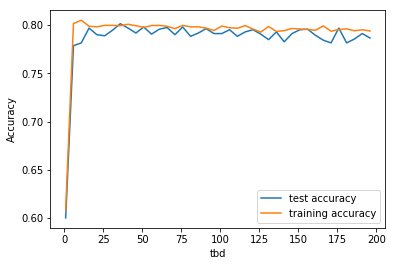

In [51]:
# initialization
training_accuracy = []
test_accuracy = [] 
# settings
rs = 0
cv_setting = 5
hl_nodes_setting = range(1, 200, 5)

for nodes in hl_nodes_setting:
    # build model (with changing parameters)
    mlp = MLPClassifier(random_state = rs, hidden_layer_sizes=(nodes,), max_iter = 50).fit(X_train_scaled, y_train)
    # record training set accuracy
    training_accuracy.append(cross_val_score(mlp, X_train_scaled, y_train, cv = cv_setting).mean())
    # record test set accuracy
    test_accuracy.append(cross_val_score(mlp, X_test_scaled, y_test, cv = cv_setting).mean())

plt.plot(hl_nodes_setting, test_accuracy, label="test accuracy")
plt.plot(hl_nodes_setting, training_accuracy, label="training accuracy")
plt.ylabel("Accuracy")
plt.xlabel("# of nodes in hidden layer")
plt.legend()

print("Max test accuracy: {} \t Corresponding # of nodes: {}".format(max(test_accuracy), hl_nodes_setting[test_accuracy.index(max(test_accuracy))]))

### Model evaluation 3 - Alpha

Max accuracy: 0.8100371909330834 	 Corresponding alpha value: 1.5


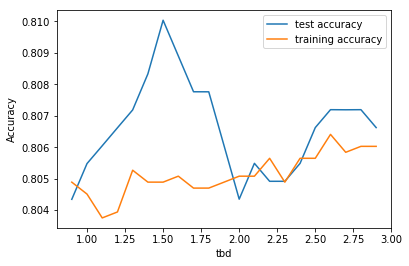

In [56]:
# initialization
training_accuracy = []
test_accuracy = [] 
# settings
rs = 0
cv_setting = 5
hl_nodes_setting = 36
alpha_setting = np.arange(0.9, 3, 0.1)


for alpha_set in alpha_setting:
    # build model (with changing parameters)
    mlp = MLPClassifier(random_state = rs, hidden_layer_sizes = (hl_nodes_setting,), alpha = alpha_set, max_iter = 50).fit(X_train_scaled, y_train)
    # record training set accuracy
    training_accuracy.append(cross_val_score(mlp, X_train_scaled, y_train, cv = cv_setting).mean())
    # record test set accuracy
    test_accuracy.append(cross_val_score(mlp, X_test_scaled, y_test, cv = cv_setting).mean())

plt.plot(alpha_setting, test_accuracy, label="test accuracy")
plt.plot(alpha_setting, training_accuracy, label="training accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Alpha value")
plt.legend()

print("Max accuracy: {} \t Corresponding alpha value: {}".format(max(test_accuracy), alpha_setting[test_accuracy.index(max(test_accuracy))]))

### Evaluation / Expected value

In [58]:
mlp = MLPClassifier(random_state = 0, hidden_layer_sizes = (36,), alpha = 1.5)
mlp.fit(X_train_scaled, y_train)

MLPClassifier(activation='relu', alpha=1.5, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(36,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [60]:
y_true = y_test
y_pred = mlp.predict(X_test_scaled)

In [63]:
matrix = confusion_matrix(y_true, y_pred, labels=["Yes", "No"])
conf_matrix = pd.DataFrame({'Positve':matrix[:,0],'Negative':matrix[:,1]}, index=["Yes", "No"])
conf_matrix

,Positve,Negative
Yes,252,215
No,138,1153


In [64]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

In [65]:
positive_rate = (tp + fn) / y_true.count()
negative_rate = (fp + tn) / y_true.count()
print(positive_rate)

0.2656427758816837


In [66]:
tp_rate = tp/ (tp + fn)
fp_rate = fp/ (fp + tn)
fn_rate = fn/ (tp + fn) 
tn_rate = tn/ (fp + tn)
print(tp_rate)
print(fp_rate)
print(fn_rate)
print(tn_rate)

0.5396145610278372
0.10689388071262587
0.4603854389721627
0.8931061192873742


In [77]:
# cost of targeting a potentially churning customer = 2$ -> every 100th customer extends contract for one year
# Avg. monthly gain = 64$ -> yearly 768$ -> BUT only every 100th customer accepts the offer (= revenue of 7,6$ - 2$ cost = 5,6$)
tp_benefit = 5.6 # customer is going to leave and we predicted it
fp_benefit = -2 # predicted that customer is going to leave but he isn't
tn_benefit = 0 
fn_benefit = 0

In [75]:
expected_value = positive_rate * ((tp_rate * tp_benefit) + (fp_rate * fp_benefit)) + negative_rate * ((tn_rate * tn_benefit) + (fn_rate * fn_benefit))
expected_value

7.970512579871675

In [79]:
#Fragen:
# Expected value müsste mit Anzahl kontaktierter Kunden multipliziert werden?
# fn benefit müsste eigentlich -5.6 sein, aber das ist dann nur relevant beim vergleich der modelle und nicht bei der analyse, ob sich der einsatz der modelle prinzipiell lohnt (da könnte tn und fn = 0 sein)